In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install neurite
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

     |████████████████████████████████| 86 kB 3.2 MB/s 
/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN2_debug.ipynb	  MRNet
 affineRegNN3.ipynb		  prototype.py
 affineRegNN_archive.ipynb	  test_data
 affineTrainingData		  test_model.png
 affine_training_data_gen.ipynb   test.png
 basic_unet.png			  utils.py
 checkpoints			 'VoxelMorph Demo.ipynb'
 generate_data2.m		  VoxelMorphNetworkStructure1.png
 layers.py			  VoxelMorphNetworkStructure2.png


In [54]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import math
from tqdm.notebook import tqdm

import layers as custom_layers

In [5]:
# ('2.5.0', '2.5.0')
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [14]:
# MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'
# fixedImg = np.load(MRI_Path.format('0701'))
MRI_Path = "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration/data/test_data/0701.npy"
fixedImg = np.load(MRI_Path)
fixedImg.shape

(52, 256, 256)

In [15]:
inputImg = np.expand_dims(fixedImg, axis=-1)
inputImg = inputImg / np.max(inputImg) # normalize
inputImg = np.expand_dims(inputImg, axis=0)

In [16]:
# Get rid of the batch dimension
imgInput = keras.Input(shape = list(inputImg.shape)[1:])
affineInput = keras.Input(shape = (12,))

# use a built layer for data transformation as in network prediction
affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, indexing="ij", shift_center=True)([imgInput, affineInput])
print(affine_warped.shape)

(None, 52, 256, 256, 1)


In [17]:
model = keras.Model(inputs=[imgInput, affineInput], outputs=affine_warped, name="affine_transformation")
model.summary(line_length=150)

Model: "affine_transformation"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             [(None, 52, 256, 256, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
input_4 (InputLayer)                             [(None, 12)]                     0                                                                   
______________________________________________________________________________________________________________________________________________________
spatial_transformer_1 (SpatialTransformer)       (None, 52, 256

## Generate gt params for affine trans matrix

Shearing transformation matrix

[$h_(ij)$: shear j axis w.r.t. i ](https://forums.sketchup.com/t/3d-shear-notation/56854), or shear in the direction of i ?


![shear](https://aws1.discourse-cdn.com/sketchup/original/3X/f/6/f660d501f621f44622b39bb60f6e0e3ca8359016.JPG)

<hr>

**Approach 1**: Fixed img to Moving img (extract affine params from inverse transformation matrix)
* Generate training data, output:
    1. affine transformed img
    2. affine trans param, 18 in total: 
        * 3 translation
        * 9 rotation (3x3 mat)
        * 3 scaling
        * 3 skewing (not really skewing)
* Potential problem: 
    * Non-uniqueness of decomposition of 3D affine transformation matrix into translation, scaling, rotation, and shearing.
    * Example of such non-uniqueness: https://math.stackexchange.com/questions/1415854/decompose-affine-transformation-including-shear-in-x-and-y
* One solution (not unique): https://math.stackexchange.com/a/78169
    * Use QR decomposition to extract rotation first (q is orthonormal and r is upper-triangular)
    * **Con**: Assume only shearing in x and y direction (y/z-axis shearing?). Maybe this assumption does not fit our data
    * **Pro**: works for any affine transformation matrix

**Approach 2**: Fixed img to Moving img (directly use the sampled affine params and avoid the inv operation)
* **Pro**: easier to get the affine params
* **Con**: using this approach means that the moving image always looks good (since we always use real images as Moving img), but this situation may not be what we want during testing.

In [46]:
def mat_to_affine_param(mat, debug=False):
    """
    Extract affine parameters from trans
    Args:
        trans: nparray, [4,4]
    Ret:
        affine params [12]:
            trans: 0-3
            rot: 3-12
            scale: 12-15
            shear: 15-18
    """
    # gt_rot = (rotZ @ rotY @ rotX)[:3, :3].flatten()
    # gt_scale = np.diag(scaling)[:3]
    # gt_param = np.concatenate([gt_trans, gt_rot, gt_scale])

    trans = mat[:3, 3]
    rot, upper_triag = np.linalg.qr(mat[:3,:3])
    scale = np.diag(upper_triag)
    shear = upper_triag/scale
    if debug:
        display(mat.tolist())
        display(trans)
        display(rot)
        display(np.diag(scale))
        display(shear)

    shear = [shear[0,1], shear[0,2], shear[1,2]]
    affine_param = np.concatenate([trans, rot.flatten(), scale, shear])
    return affine_param

def affine_param_to_mat(affine_param):
    """
    Construct affine transformation matrix from affine params
    Args:
        affine_param: nparray [18]
    ret:
        mat: [4,4]
    """
    assert len(affine_param) == 18, "affine_param needs to have length 18"
    trans, rot, scale, shear_param = affine_param[0:3], affine_param[3:12], \
                                     affine_param[12:15], affine_param[15:18]
    rot = rot.reshape((3,3))
    scale = np.diag(scale)
    shear = np.eye(3)
    shear[0,1] = shear_param[0]
    shear[0,2] = shear_param[1]
    shear[1,2] = shear_param[2]
    mat = np.eye(4)
    mat[:3,:3] = rot @ shear @ scale
    mat[:3, 3] = trans
    return mat

In [55]:
## Approach 1
output_data_dir = "data/affineTrainingData_SVD_Rot"
os.makedirs(output_data_dir, exist_ok=True)
# for i in tqdm(range(2000)):
for i in tqdm(range(500)):
    # transformedImg = np.zeros(fixedImg.shape)

    translation = np.eye(4)
    rotX = np.eye(4)
    rotY = np.eye(4)
    rotZ = np.eye(4)
    scaling = np.eye(4)

    # translation
    xTranslationRange = 5
    yTranslationRange = 30
    zTranslationRange = 30
    translation[0, 3] = xTranslationRange * random.random()
    translation[1, 3] = yTranslationRange * random.random()
    translation[2, 3] = zTranslationRange * random.random()

    # rotation
    xRotAngle = math.pi / random.uniform(8, 80)
    rotX[1, 1] = math.cos(xRotAngle)
    rotX[1, 2] = math.sin(xRotAngle)
    rotX[2, 1] = -math.sin(xRotAngle)
    rotX[2, 2] = math.cos(xRotAngle)

    yRotAngle = math.pi / random.uniform(40, 160)
    rotY[0, 0] = math.cos(yRotAngle)
    rotY[0, 2] = -math.sin(yRotAngle)
    rotY[2, 0] = math.sin(yRotAngle)
    rotY[2, 2] = math.cos(yRotAngle)

    zRotAngle = math.pi / random.uniform(40, 160)
    rotZ[0, 0] = math.cos(zRotAngle)
    rotZ[0, 1] = -math.sin(zRotAngle)
    rotZ[1, 0] = math.sin(zRotAngle)
    rotZ[1, 1] = math.cos(zRotAngle)

    scalingX = random.uniform(0.85, 1.15)
    scalingY = random.uniform(0.85, 1.15)
    scalingZ = random.uniform(0.85, 1.15)
    scaling[0, 0] = scalingX
    scaling[1, 1] = scalingY
    scaling[2, 2] = scalingZ

    transMat = translation @ rotZ @ rotY @ rotX @ scaling
    affine_param = transMat[0:3].flatten()
    affine_param = np.expand_dims(affine_param, axis=0)
    
    transformedImg = model([inputImg, affine_param])
    transformedImg = tf.squeeze(transformedImg)

    # gt affine trans params
    transMat_inv = np.linalg.inv(transMat)
    # trf_to_save = transMat_inv[0:3].flatten()
    trf_to_save = mat_to_affine_param(transMat_inv)
    
    path = os.path.join(output_data_dir, "affine{}.npz")
    f = open(path.format(i), "wb")
    np.savez(f, img = transformedImg, trf = trf_to_save)
    f.close()
    if (i % 100 == 0):
        print("Milestone: file {} has been saved.".format(i))

  0%|          | 0/500 [00:00<?, ?it/s]

Milestone: file 0 has been saved.
Milestone: file 100 has been saved.
Milestone: file 200 has been saved.
Milestone: file 300 has been saved.
Milestone: file 400 has been saved.


### Testing mat_to_affine_param & affine_param_to_mat

In [49]:
translation = np.eye(4)
rotX = np.eye(4)
rotY = np.eye(4)
rotZ = np.eye(4)
scaling = np.eye(4)

# translation
xTranslationRange = 5
yTranslationRange = 30
zTranslationRange = 30
translation[0, 3] = xTranslationRange * random.random()
translation[1, 3] = yTranslationRange * random.random()
translation[2, 3] = zTranslationRange * random.random()

# rotation
xRotAngle = math.pi / random.uniform(8, 80)
rotX[1, 1] = math.cos(xRotAngle)
rotX[1, 2] = math.sin(xRotAngle)
rotX[2, 1] = -math.sin(xRotAngle)
rotX[2, 2] = math.cos(xRotAngle)

yRotAngle = math.pi / random.uniform(40, 160)
rotY[0, 0] = math.cos(yRotAngle)
rotY[0, 2] = -math.sin(yRotAngle)
rotY[2, 0] = math.sin(yRotAngle)
rotY[2, 2] = math.cos(yRotAngle)

zRotAngle = math.pi / random.uniform(40, 160)
rotZ[0, 0] = math.cos(zRotAngle)
rotZ[0, 1] = -math.sin(zRotAngle)
rotZ[1, 0] = math.sin(zRotAngle)
rotZ[1, 1] = math.cos(zRotAngle)

scalingX = random.uniform(0.85, 1.15)
scalingY = random.uniform(0.85, 1.15)
scalingZ = random.uniform(0.85, 1.15)
scaling[0, 0] = scalingX
scaling[1, 1] = scalingY
scaling[2, 2] = scalingZ

transMat = translation @ rotZ @ rotY @ rotX @ scaling
affine_param = transMat[0:3].flatten()
affine_param = np.expand_dims(affine_param, axis=0)

transformedImg = model([inputImg, affine_param])
transformedImg = tf.squeeze(transformedImg)

# # gt affine trans params
# gt_trans = translation[:3, 3]
# gt_rot = (rotZ @ rotY @ rotX)[:3, :3].flatten()
# gt_scale = np.diag(scaling)[:3]
# gt_param = np.concatenate([gt_trans, gt_rot, gt_scale])

transMat_inv = np.linalg.inv(transMat)
display(transMat)
display(transMat_inv)

array([[ 1.04296417, -0.04317991, -0.03490904,  2.3594737 ],
       [ 0.04188716,  1.11365594,  0.05032278, 15.74425016],
       [ 0.03100417, -0.05201826,  1.10633507, 15.62805675],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

array([[  0.95641787,   0.03841132,   0.02843141,  -3.3057278 ],
       [ -0.03468823,   0.89464651,  -0.04178845, -13.35062018],
       [ -0.02843385,   0.04098853,   0.90112369, -14.66105694],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [52]:
affine_param = mat_to_affine_param(transMat_inv, debug=True)
print()
new_mat = affine_param_to_mat(affine_param)
display(transMat_inv)
display(new_mat)
np.allclose(transMat_inv, new_mat)

[[0.9564178669193775,
  0.03841131533145538,
  0.028431406661727162,
  -3.3057277982179794],
 [-0.034688231851643055,
  0.8946465091507972,
  -0.04178845150223067,
  -13.350620184921587],
 [-0.028433845071739957,
  0.04098852847935028,
  0.9011236926917682,
  -14.661056941924809],
 [0.0, 0.0, 0.0, 1.0]]

array([ -3.3057278 , -13.35062018, -14.66105694])

array([[-0.99890217, -0.03756916,  0.02798232],
       [ 0.03622909, -0.99824011, -0.04694826],
       [ 0.02969688, -0.04588295,  0.99850531]])

array([[-0.957469  ,  0.        ,  0.        ],
       [ 0.        , -0.89639578,  0.        ],
       [ 0.        ,  0.        ,  0.90253426]])

array([[ 1.00000000e+00,  5.28749117e-03, -3.49414604e-03],
       [-0.00000000e+00,  1.00000000e+00, -7.74982664e-04],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])

array([[  0.95641787,   0.03841132,   0.02843141,  -3.3057278 ],
       [ -0.03468823,   0.89464651,  -0.04178845, -13.35062018],
       [ -0.02843385,   0.04098853,   0.90112369, -14.66105694],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

array([[  0.95641787,   0.03841132,   0.02843141,  -3.3057278 ],
       [ -0.03468823,   0.89464651,  -0.04178845, -13.35062018],
       [ -0.02843385,   0.04098853,   0.90112369, -14.66105694],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

True

## Check generated training dataset

Text(0.5, 1.0, 'recon_img')

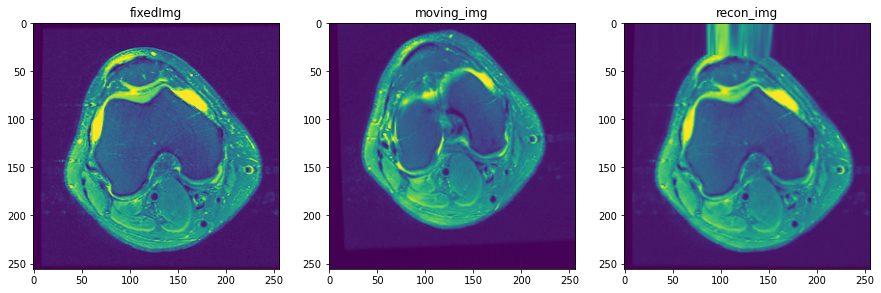

In [ ]:
trainDataPath = "./affineTrainingData/affine{}.npz"
sample_idx = random.randrange(2000)
zip_obj = np.load(trainDataPath.format(sample_idx))
moving_img = zip_obj['img']
moving_img = np.expand_dims(moving_img, axis = -1)
moving_img = np.expand_dims(moving_img, axis = 0)
target_trf = zip_obj['trf']
target_trf = np.expand_dims(target_trf, axis = 0)
recon_img = model([moving_img, target_trf])

sliceToCheck = 25
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(fixedImg[sliceToCheck, :, :])
axs[0].set_title("fixedImg")
axs[1].imshow(moving_img[0, sliceToCheck, :, :, 0])
axs[1].set_title("moving_img")
axs[2].imshow(recon_img[0, sliceToCheck, :, :, 0])
axs[2].set_title("recon_img")

## For testing purposes: check random transformed image samples

In [ ]:
transformedImg = np.zeros(fixedImg.shape)

translation = np.eye(4)
rotX = np.eye(4)
rotY = np.eye(4)
rotZ = np.eye(4)
scaling = np.eye(4)

xTranslationRange = 5
yTranslationRange = 30
zTranslationRange = 30
translation[0, 3] = xTranslationRange * random.random()
translation[1, 3] = yTranslationRange * random.random()
translation[2, 3] = zTranslationRange * random.random()

xRotAngle = math.pi / random.uniform(8, 80)
rotX[1, 1] = math.cos(xRotAngle)
rotX[1, 2] = math.sin(xRotAngle)
rotX[2, 1] = -math.sin(xRotAngle)
rotX[2, 2] = math.cos(xRotAngle)

yRotAngle = math.pi / random.uniform(40, 160)
rotY[0, 0] = math.cos(yRotAngle)
rotY[0, 2] = -math.sin(yRotAngle)
rotY[2, 0] = math.sin(yRotAngle)
rotY[2, 2] = math.cos(yRotAngle)

zRotAngle = math.pi / random.uniform(40, 160)
rotZ[0, 0] = math.cos(zRotAngle)
rotZ[0, 1] = -math.sin(zRotAngle)
rotZ[1, 0] = math.sin(zRotAngle)
rotZ[1, 1] = math.cos(zRotAngle)

scalingX = random.uniform(0.85, 1.15)
scalingY = random.uniform(0.85, 1.15)
scalingZ = random.uniform(0.85, 1.15)
scaling[0, 0] = scalingX
scaling[1, 1] = scalingY
scaling[2, 2] = scalingZ

transMat = translation @ rotZ @ rotY @ rotX @ scaling

affine_param_test = transMat[0:3].flatten()
affine_param_test = np.expand_dims(affine_param_test, axis=0)

transformedImg = model([inputImg, affine_param_test])
transformedImg = tf.squeeze(transformedImg)

In [ ]:
sliceToCheck_x = 25
sliceToCheck_y = 100
sliceToCheck_z = 100
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs[0, 0].imshow(fixedImg[sliceToCheck_x, :, :])
axs[0, 1].imshow(transformedImg[sliceToCheck_x, :, :])
axs[1, 0].imshow(fixedImg[:, sliceToCheck_y, :])
axs[1, 1].imshow(transformedImg[:, sliceToCheck_y, :])
axs[2, 0].imshow(fixedImg[:, :, sliceToCheck_z])
axs[2, 1].imshow(transformedImg[:, :, sliceToCheck_z])